# Training Vanilla GAN on CIFAR-10

In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import torch

import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
!pip install torch-summary
from torchsummary import summary
from torchvision.utils import save_image

import gitpath
HOME_PATH = gitpath.root()
sys.path.append(HOME_PATH)

from models.WGAN import *

In [2]:
class HyperParams:
    def __init__(self):
        # Constance hyperparameters. They have been tested and don't need to be tuned.
        self.n_epochs = 50
        self.batch_size = 64
        self.lr = 0.0001
        self.b1 = 0.0
        self.b2 = 0.9
        self.n_critic = 5
        self.Lipschitz_mode = 'gp'
        self.clip_value = 0.01
        self.n_workers = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 3
        self.sample_interval = 500
        self.imgsave_path = os.path.join(HOME_PATH, 'images', 'wgan1_'+self.Lipschitz_mode)
        self.CHECKPOINT_FOLDER = os.path.join(HOME_PATH, 'saved_model', 'wgan1_'+self.Lipschitz_mode)
        
params = HyperParams()
os.makedirs(params.imgsave_path, exist_ok=True)
os.makedirs(params.CHECKPOINT_FOLDER, exist_ok=True)

## Step 1: Set up preprocessing functions

In [3]:
# useful libraries
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
        ])

In [4]:
# do NOT change these
import torchvision.datasets as dset
from torch.utils.data import DataLoader

# a few arguments, do NOT change these
DATA_ROOT = os.path.join(HOME_PATH, "data")

# construct dataset
dataset = dset.CIFAR10(
    root=DATA_ROOT,
    train=True,
    download=True,
    transform=transform 
)

# construct dataloader
dataloader = DataLoader(
    dataset, 
    batch_size=params.batch_size,  # your code
    shuffle=True,
    drop_last=True,     # your code
    num_workers=params.n_workers
)

Files already downloaded and verified


## Step 3: Instantiate your SimpleNN model and deploy it to GPU devices.

In [5]:
# specify the device for computation

# GPU check                
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device =='cuda':
    print("Run on GPU...")
else:
    print("Run on CPU...")

# Model Definition  
generator = Generator(params.latent_dim).to(device)
discriminator = Discriminator().to(device)

# Check if on GPU
assert(next(generator.parameters()).is_cuda)
assert(next(discriminator.parameters()).is_cuda)

Run on GPU...


## Step 4: Set up the loss function and optimizer

In [6]:
import torch.nn as nn
import torch.optim as optim

# Add optimizer
optimizerG = optim.RMSprop(generator.parameters(), lr=params.lr)
optimizerD = optim.RMSprop(discriminator.parameters(), lr=params.lr)
if params.Lipschitz_mode == 'gp':
    optimizerG = optim.Adam(generator.parameters(), lr=params.lr, betas=(params.b1, params.b2))
    optimizerD = optim.Adam(discriminator.parameters(), lr=params.lr, betas=(params.b1, params.b2))

## Step 5: Start the training process.


In [7]:
# some hyperparameters
# total number of training epochs
start_epoch = 0

# start the training/validation process
best_loss_g = 1e20
best_loss_d = 1e20

start = time.time()
print("==> Training starts!")
print("="*50)

# store loss learning curve
g_loss_lst = []
d_loss_lst = []

fixed_random_z = torch.randn(params.batch_size, params.latent_dim).to(device)

for i in range(start_epoch, params.n_epochs):
    epoch_start = time.time()
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    g_loss = []
    d_loss = []
    
    # Train the model for 1 epoch.
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        
        inputs = inputs.float().to(device)
        batch_size = inputs.size(0)
        
        # generate fake images
        z = torch.randn(batch_size, params.latent_dim).to(device)
        gen_imgs = generator(z)
        
        ####################################
        # Train Discriminator
        ###################################
        # Ref: WGAN paper page 8 Algo 1
        
        # satisfy Lipschitz constraint
        if params.Lipschitz_mode == 'clipping':
            for p in discriminator.parameters():
                p.data.clamp_(-params.clip_value, params.clip_value)
            loss_real = torch.mean(discriminator(inputs))
            loss_fake = -torch.mean(discriminator(gen_imgs.detach()))
            loss_D = loss_fake + loss_real

            # backpropagation
            optimizerD.zero_grad()
            loss_D.backward()
            optimizerD.step()

        if params.Lipschitz_mode == 'gp':
            from torch import autograd
            # Ref: WGAN-GP paper Algo 1
            # Ref: https://github.com/caogang/wgan-gp.git
            GP_LAMBDA = 10

            inputs = torch.randn(64,3,32,32).to(device)
            gen_imgs = torch.randn(64,3,32,32).to(device)

            epi = torch.rand(batch_size, 1, 1, 1).expand_as(inputs).type_as(inputs).to(device)
            # epi = epi.expand(params.batch_size, params.channels * params.img_size**2).contiguous().view(params.batch_size, 3, 32, 32).to(device)

            # print(epi.shape, inputs.shape, gen_imgs.shape)

            interpolates = (epi * inputs + ((1 - epi) * gen_imgs)).to(device)
            # interpolates.requires_grad_()
            interpolates = autograd.Variable(interpolates, requires_grad=True)
            
            # Compute Wasserstein Loss against perturbed data
            loss_inter = torch.mean(discriminator(interpolates))
            grad_outputs = torch.ones(loss_inter.size()).type_as(loss_inter.data)
            
            # # # Compute gradients
            # loss_inter.backward(retain_graph=True)
            # gradients = interpolates.grad.data
            gradients = autograd.grad(
                            outputs=loss_inter,
                            inputs=interpolates,
                            grad_outputs=grad_outputs,
                            create_graph=True,
                            only_inputs=True)[0]

            gradients = gradients.view(gradients.size(0), -1)
            gradient_penalty = GP_LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

            loss_real = torch.mean(discriminator(inputs))
            loss_fake = torch.mean(discriminator(gen_imgs.detach()))
            loss_D_gp = -loss_fake + loss_real - gradient_penalty

            if (batch_idx % params.sample_interval == 0): 
                print(gradients.norm(2, dim=1)[0:10])
                print(((gradients.norm(2, dim=1) - 1) ** 2).mean())

            # backpropagation
            optimizerD.zero_grad()
            loss_D_gp.backward()
            optimizerD.step()
            
            loss_D = -loss_fake + loss_real

        # calculate percentage of confidence
        d_loss.append(loss_D.cpu().detach().numpy())

        ####################################
        
        if batch_idx + 1 % params.n_critic == 0:
            ####################################
            # Train Generator
            ###################################
            # maximize generator's ability to fool discriminator

            # compute loss
            loss_G = torch.mean(discriminator(gen_imgs))
            
            # backpropagation
            optimizerG.zero_grad()
            loss_G.backward()
            optimizerG.step()

            # calculate percentage of confidence
            g_loss.append(loss_G.cpu().detach().numpy())
            ####################################
        
        if (batch_idx % params.sample_interval == 0): 
            batches_done = i * len(dataloader) + batch_idx
            save_image(generator(fixed_random_z).data[:40], os.path.join(params.imgsave_path, "%d.png" % batches_done), nrow=5, normalize=True)
        
    avg_loss_g = np.sum(np.asarray(g_loss)) / len(g_loss)
    avg_loss_d = np.sum(np.asarray(d_loss)) / len(d_loss)
    print("Generator loss: %.4f, Discriminator loss: %.4f"%(avg_loss_g, avg_loss_d))
    
    g_loss_lst.append(avg_loss_g)
    d_loss_lst.append(avg_loss_d)
    
    # save the model checkpoint
    state_G = generator.state_dict()
    torch.save(state_G, os.path.join(params.CHECKPOINT_FOLDER, 'generator.pth'))
    state_D = discriminator.state_dict()
    torch.save(state_D, os.path.join(params.CHECKPOINT_FOLDER, 'discriminator.pth'))
    print(f"Epoch finished in {time.time() - epoch_start:.2f}s")
    print("")

print("="*50)
print(f"==> Optimization finished in {time.time() - start:.2f}s!")

==> Training starts!
Epoch 0:
tensor([0.0006, 0.0006, 0.0005, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0006], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(0.9989, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([0.0113, 0.0107, 0.0106, 0.0118, 0.0116, 0.0108, 0.0107, 0.0114, 0.0113,
        0.0111], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(0.9777, device='cuda:0', grad_fn=<MeanBackward0>)
Generator loss: -0.1328, Discriminator loss: -0.0009
Epoch finished in 33.15s

Epoch 1:
tensor([0.0604, 0.0605, 0.0591, 0.0639, 0.0623, 0.0599, 0.0619, 0.0613, 0.0615,
        0.0578], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(0.8806, device='cuda:0', grad_fn=<MeanBackward0>)
tensor([0.8169, 0.7767, 0.8128, 0.7747, 0.7612, 0.7569, 0.7992, 0.7672, 0.7723,
        0.7709], device='cuda:0', grad_fn=<SliceBackward0>)
tensor(0.0472, device='cuda:0', grad_fn=<MeanBackward0>)
Generator loss: -0.9377, Discriminator loss: -0.1501
Epoch finished in 26.61s

Epoch 2:
tensor

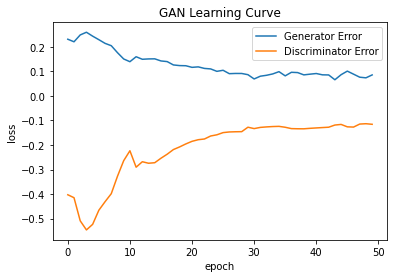

In [ ]:
plt.plot(g_loss_lst, label='Generator Error')
plt.plot(d_loss_lst, label='Discriminator Error')
plt.title("GAN Learning Curve")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()